In [3]:
from colorsys import rgb_to_hls, hls_to_rgb
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
import matplotlib.animation as animation

%matplotlib notebook

In [347]:
class InteractiveBarPlot:
    
    def __init__(self, title='Init title', colormap='Spectral', colorslice=[0.09, 0.89], 
                 yrange=[0, 10], xrange=[0, 10], figsize=(9,8)):
        
        fig = plt.figure(constrained_layout=True, figsize=figsize)
        gs = fig.add_gridspec(2, 1, height_ratios=[5, 1])
        
        ax = fig.add_subplot(gs[0])
        ax1 = fig.add_subplot(gs[1])
        
        self.figure = fig
        self.ax = ax
        
        self.xrange = xrange
        self.yrange = yrange
        
        self.ax.set_xlim(xrange)
        self.ax.set_ylim(yrange)
        self.ax.set_title(title)
        self.ax.spines['top'].set_visible(False)
        self.ax.spines['right'].set_visible(False)
        self.ax.xaxis.set_visible(False)
        
        self.__FACTOR = 0.7
        
        self.colormap = cm.get_cmap(name=colormap)
        
        self.mincolor = colorslice[0]
        self.maxcolor = colorslice[1]
        self.coloredges = (self.colormap(self.mincolor), self.colormap(self.mincolor), self.colormap(self.maxcolor))
        
        cmap = np.outer(np.ones(30), np.arange(0, 1, 0.001))
        ax1.imshow(cmap, cmap=self.colormap)
        ax1.set_xlim([1000*self.mincolor, 1000*self.maxcolor])
        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_visible(False)
        
        self.values = []
        self.colors = []
        self.err = []
        self.edgecolors = []
        self.widths = []
        self.widths_scale = []
        self.positions = []
        self.indexes = []
        
        self.__delta = 0
        self.mean = 0
        self.top_lim = 0
        self.bot_lim = 0
        self.errlinesize = 14
        self.fontsize = 14
        self.common_width = 0
        self.bar_graph = None
        self.bar_graph_bars = None
        self.line_top = None
        self.line_bot = None
        self.line_mean = None
        self.fill_between = None
        self.scat_top = None
        self.scat_bot = None
        self.graph_labels = None
        self.labels_data = None
        self.line_labels = None
        self.top_clicked = False
        self.bot_clicked = False
        self.cent_clicked = False
        
        self.cent_cent = 0
        self.cent_top = 0
        self.cent_bot = 0
        
        
        self.new_width = lambda l: self.common_width*l/np.sum(self.widths_scale)
        self.new_pos = lambda i: np.sum(self.widths[:i]) + np.mean([self.widths[i], self.widths[0]]) + (i + 1)*0.2
        
        self.vect_update_colors = np.vectorize(self.__update_color, otypes=[list])
        self.vect_update_width = np.vectorize(self.new_width, otypes=[list])
        self.vect_update_pos = np.vectorize(self.new_pos, otypes=[list])
        self.vect_add_labels = np.vectorize(self.__add_bar_label, otypes=[list])
          
    def __change_color(self, color, amount=0.5):
    
        try:
            c = mc.cnames[color]
        except:
            c = color
            
        c = rgb_to_hls(*mc.to_rgb(c))
        
        return hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
        
    def __update_color(self, index):
        
        scale = 1

        top = max(self.bot_lim, self.top_lim)
        bot = min(self.bot_lim, self.top_lim)
        self.mean = np.mean([top, bot])
        mean = self.mean
        
        value = self.values[index]
        
        if bot < value < top:
            
            dist = (value - bot) / (top - bot)
            scale += dist if dist <= 0.5 else 1 - dist
            color = self.colormap(self.mincolor + dist*(self.maxcolor - self.mincolor))

        else:
            
            sign = np.sign(bot - value).astype('int64')
            color = self.coloredges[sign]
            
        self.colors[index] = color
        self.edgecolors[index] = self.__change_color(color, 0.7)
        self.widths_scale[index] = scale
    
    def __update_colors(self):
        
        self.vect_update_colors(self.indexes)
        
        
        self.widths = self.vect_update_width(self.widths_scale)
        self.positions = self.vect_update_pos(self.indexes)
    
    def __add_bar_label(self, index):
        
#         bar = self.bar_graph_bars[index]
#         height = bar.get_height()

        text = self.graph_labels[index]
        ratio = 1 if len(text) == 1 else 1/np.log(len(text))
        fontsize = self.widths[index]*self.fontsize*ratio + 0.4
        
        y_position = (min(self.values[index], self.yrange[1]) + self.yrange[0]) / 2.0
        
        self.labels_data[index] = self.ax.text(self.positions[index], y_position,
                                              text, ha='center', va='bottom',
                                              color=self.__change_color(self.colors[index], 0.55),
                                              fontsize=fontsize)
    
    def __add_bar_labels(self):
        
        self.__update_line_labels()
        
        if not self.graph_labels is None:
            
            self.vect_add_labels(self.indexes)
    
    def __update_line_labels(self):
        
        print('asf')
        print(self.labels_data)
        self.line_labels[0] = self.ax.text(self.xrange[1]*0.95, self.top_lim, round(self.top_lim, 1), 
                           ha='left', va='center', fontsize=14, color='#4AA0C3')
        self.line_labels[1] = self.ax.text(self.xrange[1]*0.95, self.bot_lim, round(self.bot_lim, 1), 
                           ha='left', va='center', fontsize=14, color='#4AA0C3')
        self.line_labels[2] = self.ax.text(self.xrange[1]*0.95, self.mean, round(self.mean, 1), 
                           ha='left', va='center', fontsize=12, color='#4AA0C3')
            
            
        
    def __plot(self, draw_tline=True, draw_bline=True, draw_mline=True):
        
        self.__update_colors()
        
        self.bar_graph = self.ax.bar(self.positions, self.values, yerr=self.err,
                                    capsize=self.errlinesize*np.min(self.widths), 
                                    color=self.colors, linewidth=1,
                                    edgecolor=self.edgecolors, width=self.widths)
        
        self.__add_bar_labels()
        
        self.fill_between = self.ax.fill_between([0, self.xrange[1]*0.9], [self.top_lim, self.top_lim], 
                                                 [self.bot_lim, self.bot_lim], color='skyblue', alpha=0.15)
        
        if draw_mline:
            
            self.line_mean, = self.ax.plot([0, self.xrange[1]*0.9], [self.mean, self.mean], 
                                          color='skyblue', linewidth=1.5, alpha=0.6, linestyle='dotted')
        
        if draw_tline:
            
            self.line_top, = self.ax.plot([0, self.xrange[1]*0.9], [self.top_lim, self.top_lim], 
                                          color='skyblue', linewidth=1.5, alpha=0.4)
            
            self.scat_top = self.ax.scatter(self.xrange[1]*0.9, self.top_lim, marker='o', 
                                            color='skyblue', s=80, zorder=10)
        
        if draw_bline:
            
            self.line_bot, = self.ax.plot([0, self.xrange[1]*0.9], [self.bot_lim, self.bot_lim], 
                                          color='skyblue', linewidth=1.5, alpha=0.4)
            
            self.scat_bot = self.ax.scatter(self.xrange[1]*0.9, self.bot_lim, marker='o', 
                                            color='skyblue', s=80, zorder=10)
    
    def __connect_events(self):
        
        self.figure.canvas.mpl_connect('button_press_event', self.__on_drag_start)
        self.figure.canvas.mpl_connect('motion_notify_event', self.__drag_event)
        self.figure.canvas.mpl_connect('button_release_event', self.__on_drag_end)
        self.figure.canvas.mpl_connect('axes_leave_event', self.__on_drag_end)
        self.figure.canvas.mpl_connect('scroll_event', self.__on_scroll)
    
    def __on_drag_start(self, event):
        
        shift = self.__FACTOR * abs(self.top_lim - self.bot_lim)
        
        if self.top_lim - self.__delta < event.ydata < self.top_lim + self.__delta:
            self.top_clicked = True
        
        elif self.bot_lim - self.__delta < event.ydata < self.bot_lim + self.__delta:
            self.bot_clicked = True
        
        elif self.mean - shift < event.ydata < self.mean + shift:
            self.cent_cent = event.ydata
            self.cent_top = self.top_lim
            self.cent_bot = self.bot_lim
            self.cent_clicked = True

    
    def __drag_event(self, event):
        
        if self.top_clicked:
            
            self.line_top.remove()
            self.line_mean.remove()
            self.fill_between.remove()
            self.scat_top.remove()
            self.bar_graph.errorbar.remove()
            _ = [p.remove() for p in self.bar_graph.patches]
            _ = [l.remove() for l in self.line_labels]
            
            if self.labels_data: _ = [l.remove() for l in self.labels_data]
            
            self.top_lim = event.ydata
            
            self.__plot(draw_bline=False)
        
        if self.bot_clicked:
            
            self.line_bot.remove()
            self.line_mean.remove()
            self.fill_between.remove()
            self.scat_bot.remove()
            self.bar_graph.errorbar.remove()
            _ = [p.remove() for p in self.bar_graph.patches]
            _ = [l.remove() for l in self.line_labels]
            
            if self.labels_data: _ = [l.remove() for l in self.labels_data]
                
            self.bot_lim = event.ydata
            
            self.__plot(draw_tline=False)
        
        if self.cent_clicked:
            
            self.line_bot.remove()
            self.line_top.remove()
            self.line_mean.remove()
            self.fill_between.remove()
            self.scat_bot.remove()
            self.scat_top.remove()
            self.bar_graph.errorbar.remove()
            _ = [p.remove() for p in self.bar_graph.patches]
            _ = [l.remove() for l in self.line_labels]
            
            if self.labels_data: _ = [l.remove() for l in self.labels_data]
                
            self.top_lim = self.cent_top + (event.ydata - self.cent_cent)
            self.bot_lim = self.cent_bot + (event.ydata - self.cent_cent)
            
            if self.top_lim < self.yrange[0]:
                self.top_lim = self.yrange[0]
                self.bot_lim = abs(self.cent_top - self.cent_bot)

            elif self.top_lim > self.yrange[1]: 
                self.top_lim = self.yrange[1]
                self.bot_lim = self.yrange[1] - abs(self.cent_top - self.cent_bot)

            elif self.bot_lim < self.yrange[0]: 
                self.top_lim = abs(self.cent_top - self.cent_bot)
                self.bot_lim = self.yrange[0]

            elif self.bot_lim > self.yrange[1]: 
                self.top_lim = self.yrange[1] - abs(self.cent_top - self.cent_bot)
                self.bot_lim = self.yrange[1]

            self.__plot()
            
    def __on_drag_end(self, event):
        
        self.cent_clicked = False
        self.top_clicked = False
        self.bot_clicked = False
    
    def __on_scroll(self, event):
    
        shift = event.step*(self.yrange[1] - self.yrange[0])*0.01
        
        if self.top_lim + shift > self.yrange[1]:
            self.top_lim = self.yrange[1]
            
        elif self.top_lim + shift < self.yrange[0]:
            self.top_lim = self.yrange[0]
            
        else:
            self.top_lim += shift
            
        if self.bot_lim - shift > self.yrange[1]:
            self.bot_lim = self.yrange[1]
            
        elif self.bot_lim - shift < self.yrange[0]:
            self.bot_lim = self.yrange[0]
            
        else:
            self.bot_lim -= shift
        
        if abs(self.top_lim - self.bot_lim) < (self.yrange[1] - self.yrange[0])*0.08:
            
            sign = np.sign(self.top_lim - self.bot_lim)
            self.top_lim = self.mean + sign*(self.yrange[1] - self.yrange[0])*0.04
            self.bot_lim = self.mean - sign*(self.yrange[1] - self.yrange[0])*0.04
        
        self.line_bot.remove()
        self.line_top.remove()
        self.line_mean.remove()
        self.fill_between.remove()
        self.scat_bot.remove()
        self.scat_top.remove()
        self.bar_graph.errorbar.remove()
        _ = [p.remove() for p in self.bar_graph.patches]
        _ = [l.remove() for l in self.line_labels]

        if self.labels_data: _ = [l.remove() for l in self.labels_data]
        
        self.__plot()
        
        
        
    def set_lims(self, top_lim=10, bot_lim=0):
        
        self.top_lim = top_lim
        self.bot_lim = bot_lim
        self.mean = np.mean([top_lim, bot_lim])
        
    def add_data(self, values=[], err=[], autoscaley=True, autoscalex=True, labels=None, errlinesize=14, fontsize=14):
        
        self.values = np.array(values)
        self.err = np.array(err)
        self.__delta = np.max(self.values) * 0.02
        
        size = self.values.size
        
        self.colors = [0 for i in range(size)]
        self.edgecolors = [0 for i in range(size)]
        self.widths = [0 for i in range(size)]
        self.widths_scale = [0 for i in range(size)]
        self.indexes = np.array([i for i in range(size)])
        self.line_labels = [0, 0, 0]
        self.common_width = size
        self.errlinesize = errlinesize
        self.fontsize = fontsize
        
        if autoscalex:
            
            self.xrange = [0, round(size*1.5, 0)]
            self.ax.set_xlim(self.xrange)
            
            
        if autoscaley:
            
            self.yrange = [0, round(np.max(self.values)*1.1, 0)]
            self.ax.set_ylim(self.yrange)
        
        print(self.yrange)
        
        self.bot_lim = self.yrange[0]*1.1
        self.top_lim = self.yrange[1]*0.9

        if not labels is None and np.array(labels).size == size:
            
            self.graph_labels = labels
            self.labels_data = [0 for i in range(size)]
    
    def launch(self):
        
        self.__connect_events()
        self.__plot()
        

<IPython.core.display.Javascript object>


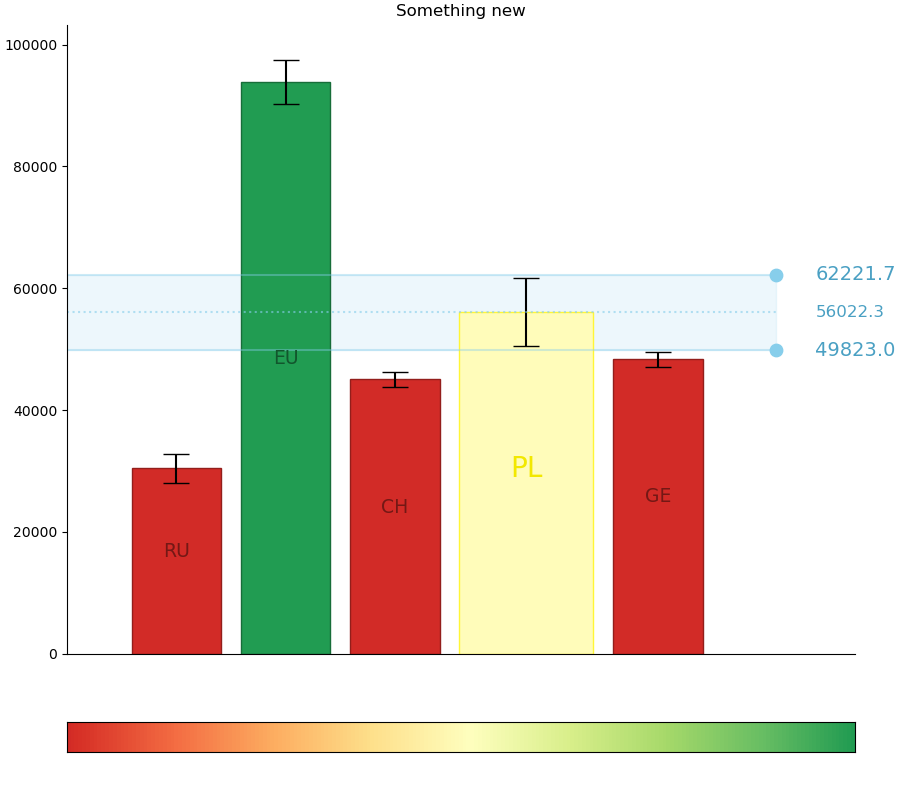

[0, 103323.0]
asf
[0, 0, 0, 0, 0]


In [354]:
vals = [30404, 93930, 45012, 56040, 48303]
errs = [2400, 3624, 1242, 5603, 1241]
labs = ['RU', 'EU', 'CH', 'PL', 'GE']

new_bar = InteractiveBarPlot(title='Something new', yrange=[40000, 70000], colormap='RdYlGn')
new_bar.add_data(vals, errs, labels=labs, errlinesize=10, fontsize=10)
new_bar.launch()